## Problem 7.21

Here we produce a 1D SEM solver to the wave equation. As with Problem 7.20, this relies on a number of functions we developed in previous problems 7.17 - 7.19, which are copied in the hidden cell below. Similarly, a lot of the domain setup is identical to Problem 7.20, so is only commented on briefly. 

In [1]:
# Hidden cell with functions: 
import scipy.special as ss 
import numpy as np 
import matplotlib.pyplot as plt 
from copy import copy

def gll(n, Nsegs=100): 
    # This function is the solution to 7.17. 
    # It is not the most efficient way to compute GLL points,
    # but it works!
    nroots  = n + 1              # Number of roots
    roots   = np.zeros(nroots)   # Array to hold all the roots
    leg_n   = ss.legendre(n)    # P_n  
    leg_n_1 = ss.legendre(n-1)  # P_{n-1}

    def compute_functional(xi, n, lnm1, ln):
        return n * (lnm1(xi) - xi * ln(xi))
    
    # End points 
    roots[0]   = -1
    roots[-1]  =  1
    nrts_found =  2

    if nroots > 3:
        xi_end = 0.99999
        if n%2==0:
            xi_start = 0.00001
            nrts_found += 1
        else:
            xi_start = 0.0
        segments = np.linspace(xi_start, xi_end, Nsegs)
        fseg = compute_functional(segments, n, leg_n_1, leg_n)
        # Index in the 'roots' array to store the root
        idx = int(nroots / 2) + nroots%2 
        # Loop through each segment and test if root lies within
        for iseg in range(Nsegs-1):
            if fseg[iseg] == 0:
                # Root found exactly here
                error = 0
                nrts_found += 1
            elif fseg[iseg+1] == 0:
                # Root found exactly here
                error = 0
                nrts_found += 1
            elif fseg[iseg] * fseg[iseg+1] < 0:
                # There is a change in sign between the two values:
                # Start with the current edge xi positions of the 'segment'
                a = segments[iseg]
                b = segments[iseg+1]
                error = 999
                while np.abs(error) > 1e-9:
                    grad =  compute_functional(b, n, leg_n_1, leg_n) \
                          - compute_functional(a, n, leg_n_1, leg_n)
                    this_root = a + (b-a)/2
                    error    =  compute_functional(this_root, n, leg_n_1, leg_n)
                    if error !=0:
                        if grad*error > 0:
                            b = copy(this_root)
                        else:
                            a = copy(this_root)
                roots[idx] = this_root
                idx += 1
                nrts_found+=2
                
        for irt in range(1, int(n/2) + n%2):
            i1 = int(nroots/2) -irt
            i2 = int(nroots/2) +irt  - n%2 
            roots[i1] = -roots[i2]
        return roots 
    

def lagrange(N, a, x, GLL):
    # Computes a'th Lagrange polynomial of degree N at points x
    # using control points specified in GLL array
    poly = 1
    for j in range(0, N+1):
        if j != a:
            poly = poly * ((x - GLL[j]) / (GLL[a] - GLL[j]))
    return poly


def weights(n): 
    # n is degree of lagrange 
    # returns the n+1 gll points and 
    # corresponding weights
    
    # Compute the n+1 GLL points
    gllpts = gll(n)

    # Define the domain interval [-1, +1] on 1000 points:
    x = np.linspace(-1, 1, 1000)

    weights = []
    # Loop over the n+1 polynomials to compute the weights
    for alpha in range(n+1): 
        # Integrand is simply the alpha'th lagrange polynomial of degree n
        integrand = lagrange(n, alpha, x, gllpts)

        # Trapezoid rule to integrate
        weights.append(np.trapz(y=integrand, x=x))
    return gllpts, np.array(weights)


def dlagrange1(n): 
    # Computing deriv of lagrange specifically at GLL points: 
    # Using method in Canuto et al 2006
    # for degree n lagrange polynomials
    # RETURNS: 
    # 2D numpy array: 
    # [i,j] represents the derivative of the i'th lagrange polynomial 
    # at the xi position of the j'th GLL point
    # e.g. [i,j] is l^n'_i(xi_j)
    gllpts = gll(n)
    
    derivatives = []
    for i in range(n+1):
        # Loop over GLL points 
        derivs = []

        leg_n = ss.legendre(n)
        for j in range(n+1):
            if i == 0 and j == 0:
                derivs.append(-(n+1)*n/4)
            elif i == n and j == n: 
                derivs.append((n+1)*n/4)
            elif i != j:  
                derivs.append(leg_n(gllpts[j]) / ( leg_n(gllpts[i]) * (gllpts[j]-gllpts[i]) ))
            else: 
                derivs.append(0) 
                
        derivatives.append(derivs)
    return np.array(derivatives)

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Setting up the domain

Let us define our domain as the problem prescribes. Here we are using 7 GLL points and 12 elements for the domain $x\in[0,\,1]$. Note that the timestep needs to be quite small here to satisfy the CFL condition since our wavespeed is 1, and the whole domain size is also 1. 

In [2]:
# Domain discretisation
L      = 1           # Domain size
n      = 6           # Lagrange degree
ngll   = n + 1       # number of gll per element
nelmts = 12          # Number of elements
nbound = nelmts + 1  # Number of element boundaries

# Timestepping
dt        = 0.0005   # Timestep 
nsteps    = 4000     # Number of timesteps
plotevery = 100      # Timestep to plot

# Physical properties
rho    = 1 
mu     = 1 


# Global coordinates of element boundaries:
elembnds = np.linspace(0, L, nbound)
# Length of each element
elemsize = elembnds[1:] - elembnds[:-1]

# Get GLL and weights: 
xigll, wgll = weights(n)

# Create an array of the GLOBAL node coordinates: 
nglob = nelmts*(ngll-1) + 1

# Array of global node x coordinates
# and ibool (lobal --> global mappping)
xcoord = np.zeros(nglob)
ibool = np.zeros((ngll, nelmts)).astype(int)
for ielem in range(nelmts): 
    xcoord[n*ielem : n*ielem+ngll] \
       = elembnds[ielem] + elemsize[ielem]*(xigll+1)/2
    ibool[:, ielem] = np.arange(n*ielem, n*ielem+ngll)
    
# Derivative of lagrange polynomials
dlag1 = dlagrange1(n)


# Compute jacobian
jac = np.zeros((ngll, nelmts))
for ielem in range(nelmts):
    for gamma in range(ngll): 
        
        # Evaluate sum over a 
        for igll in range(ngll): 
            jac[gamma, ielem] +=             \
                  xcoord[ibool[igll, ielem]] \
                  * dlag1[igll, gamma]

#### Assembly of the matrices 

Two major benefits of the Spectral Element Method are: 
- The diagonal mass matrix
- No requirement to assemble the global stiffness matrix

Note here that the global stiffness matrix is a square matrix 
with dimensions equal to the global degrees of freedom. This 
becomes prohibative to assemble for realistic simulations. 
As we will see below, we only ever require access to the matrix-vector
product $\mathsf{K} \mathsf{s}$, which is a vector. Hence, in 
real SEM software the matrix-vector product is computed at the elemental
level, and only the resultant vector is assembled. Here, however, 
we will assemble the stiffness matrix for clarity. 

The two elemental matrices are described in Eqns. 7.132 and 7.136 for the 
mass matrix and stiffness matrix respectively. 

In [3]:
# Initialise mass 'matrix'
# only a vector since diagonal
M = np.zeros(nglob)

# For each element we can construct the local 
# matrix and assemble: 
for ielem in range(nelmts):
    for igll in range(ngll): 
        iglob = ibool[igll, ielem]
        mass_local = wgll[igll] * jac[igll,ielem] * rho
        M[iglob] +=  mass_local

# Create the K matrix even though we dont 
# need to assemble it technically 
K = np.zeros((nglob, nglob))

# Eqn. 7.136 
for ielem in range(nelmts):
    # Loop over GLL pts (a,b)
    for a in range(ngll): 
        iglob_a = ibool[a, ielem]
        
        for b in range(ngll): 
            iglob_b = ibool[b, ielem]

            # Sum over gamma:
            gsum = 0 
            for g in range(ngll): 
                gsum += (wgll[g] * mu * dlag1[a,g] * 
                         dlag1[b,g] / jac[g,ielem])
            # Assemble to global matrix
            K[iglob_a, iglob_b] += gsum

### A comment on the initial condition

The initial condition within the problem statement, 
\begin{equation*}
s(x,\,0) = \exp \left[ -0.1 ( x - 0.5 )^2 \right]
\end{equation*}
is plotted below. Note however that this is a very long-wavelength displacement relative to the size of the domain. As such, the resultant wave propagation resembles that of a plucked guitar string. We will also simulate a second, shorter-wavelength initial condition to observe clearer propagation of the wave and interaction with the boundary. This initial condition will be
\begin{equation*}
s(x,\,0) = \exp \left[ - 100 *( x - 0.5 )^2  \right]
\end{equation*}
which is also plotted below: 

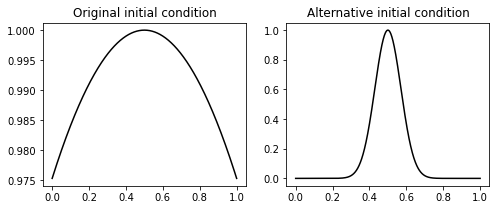

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
xp = np.linspace(0, 1, 1000)
ax[0].plot(xp, np.exp(-0.1 * (xp-0.5)**2 ), 'k');
ax[0].set_title('Original initial condition');
ax[1].plot(xp, np.exp(-100 * (xp-0.5)**2 ), 'k');
ax[1].set_title('Alternative initial condition');

### Neumann boundary condition

Let us start with the Neumann boundary condition since it is easier! Note that the boundary conditions 
\begin{align*}
\partial_x s(0, t) &= 0 \\ 
\partial_x s(L, t) &= 0 \\ 
\end{align*}

are naturally satisfied by setting the forcing term, $f_\alpha$, (Eqn. 7.138) equal to zero. That is, we only need to solve a modified version of the system of equations in Eqn. 7.137 as 
\begin{align*}
\sum_{\beta=0}^n \left( m_{\alpha\beta} \ddot{s}_\beta + k_{\alpha\beta} s_\beta \right) = 0
\end{align*}

#### Alternative initial condition

Below, we simulate first for our alternative initial condition. We observe the propagation of the wave away from the centre. At the boundaries, the stress-free surface allows for non-zero displacement. 

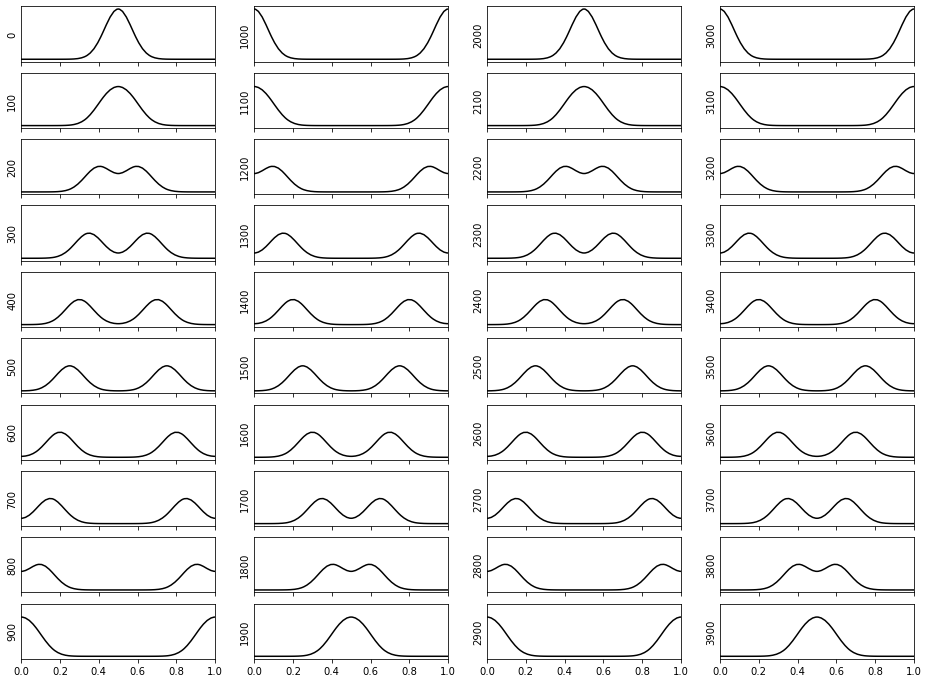

In [5]:
# Initialise the disp, vel, acc: 
disp = np.zeros(nglob)
vel  = np.zeros(nglob)
acc  = np.zeros(nglob)

disp = np.exp(- ((xcoord-0.5)**2) /0.01  )

# Plot the initial condition
fig, ax = plt.subplots(10,4, figsize=(16,12), sharex=True, sharey=True)

# Loop in time 
iax  = 0
icol = 0
for istep in range(nsteps): 

    # Predictor: 
    newdisp = disp + dt*vel + 0.5*dt*dt*acc 
    newvel  = vel  + 0.5*dt*acc 
    newacc  = acc*0 

    # Solver: 
    Da = - np.matmul(K, newdisp)/ M

    # Corrector:
    newacc  += Da
    newvel  += 0.5*dt*newacc

    # Now need to copy to old arrays: 
    disp[:] = copy(newdisp[:])
    vel[:] = copy(newvel[:])    
    acc[:] = copy(newacc[:])    


    if istep%plotevery == 0:
        ax[iax, icol].plot(xcoord, disp, 'k')
        ax[iax, icol].set_ylabel(istep)
        ax[iax, icol].set_yticks([])

        iax += 1
        if iax==10:
            icol +=1 
            iax  = 0 
        
ax[0,0].set_xlim([0,1]);

We observe the wave propagating to the boundary and being reflected. 

#### Original initial condition

Next, let us re-run the code with the original initial condition. This is the type of propagation one would see when plucking a (broken!) guitar string, if the ends of the string were not fixed, perhaps more similar to wobbling a sheet of plastic.

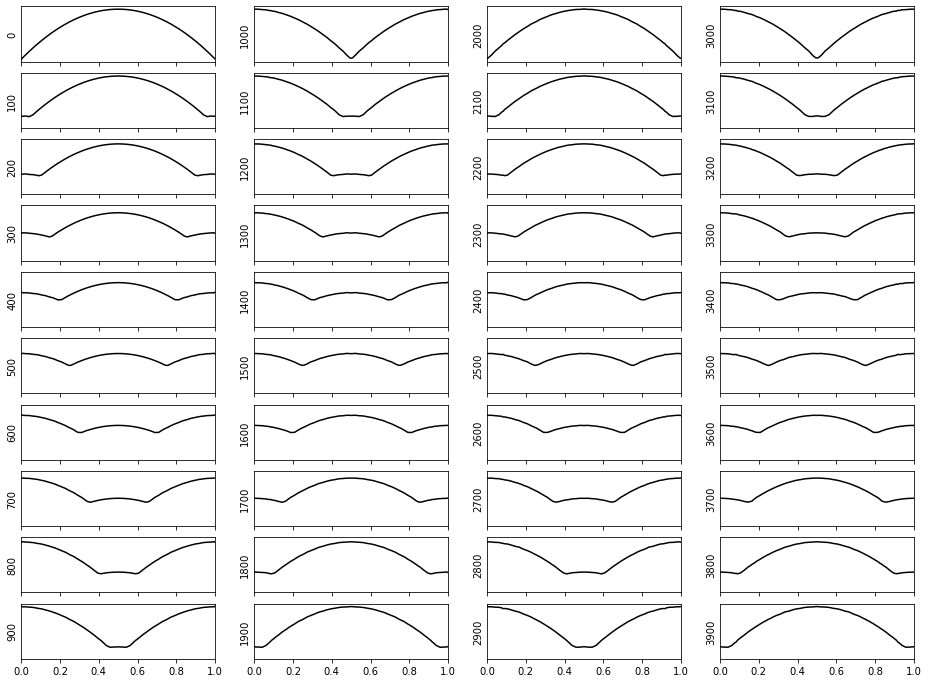

In [6]:
# Initialise the disp, vel, acc: 
disp = np.zeros(nglob)
vel  = np.zeros(nglob)
acc  = np.zeros(nglob)

nsteps     = 4000
disp = np.exp(- 0.1*((xcoord-0.5)**2))


fig, ax = plt.subplots(10,4, figsize=(16,12), sharex=True, sharey=True)

# Loop in time 
iax  = 0
icol = 0
for istep in range(nsteps): 

    # Predictor: 
    newdisp = disp + dt*vel + 0.5*dt*dt*acc 
    newvel  = vel  + 0.5*dt*acc 
    newacc  = acc*0 

    # Solver: 
    Da = - np.matmul(K, newdisp)/ M
    
    # Corrector:
    newacc  += Da
    newvel  += 0.5*dt*newacc

    # Now need to copy to old arrays: 
    disp[:] = copy(newdisp[:])
    vel[:]  = copy(newvel[:])    
    acc[:]  = copy(newacc[:])    

    if istep%plotevery == 0:
        ax[iax, icol].plot(xcoord, disp, 'k')
        ax[iax, icol].set_ylabel(istep)
        ax[iax, icol].set_yticks([])

        iax += 1
        if iax==10:
            icol +=1 
            iax  = 0 
        
ax[0,0].set_xlim([0,1]);

### Dirichlet boundary condition

Finally, let us implement a Dirichlet boundary condition. The code is very similar, except we must now implement the forcing term as a contribution to the RHS. This acts only on the GLL points that represent the boundary of the domain. 

#### Original initial condition


**Note: the original initial condition specified in the question has displacement values of $\sim$ 0.97 at the edges of the domain, yet the dirichlet condition says the boundaries should have a displacement of 0. Hence, let us modify the initial condition by a constant so that the edges of the domain are initially at 0, i.e.**

\begin{equation*}
s(x,\,0) = \exp \left[ -0.1 ( x - 0.5 )^2 \right] - 0.97\dots
\end{equation*}

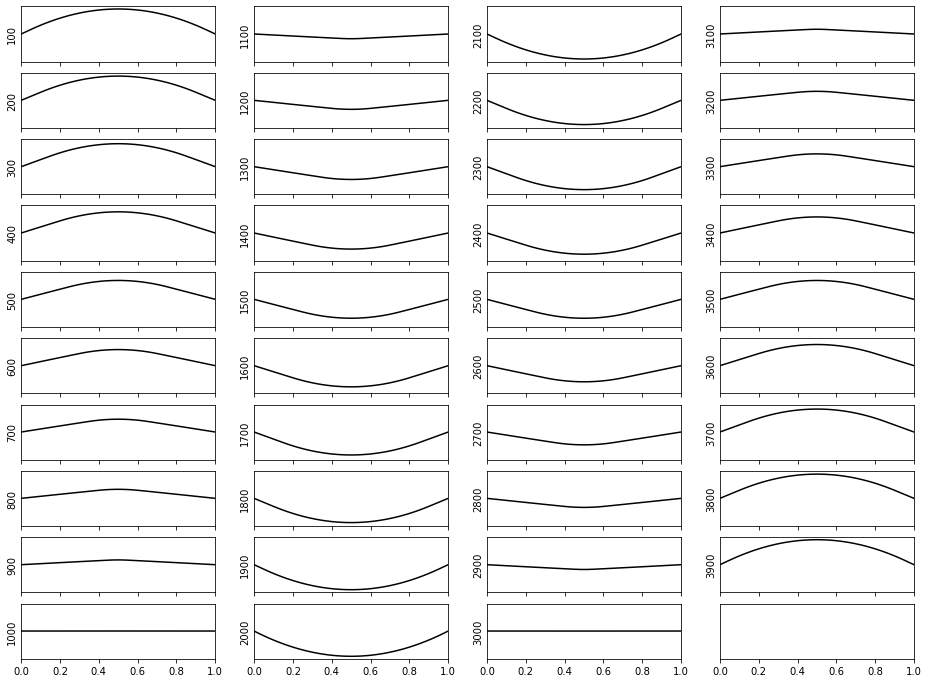

In [7]:
# Initialise the disp, vel, acc: 
disp = np.zeros(nglob)
vel  = np.zeros(nglob)
acc  = np.zeros(nglob)

# Apply initial condition: 
disp = np.exp(- 0.1*((xcoord-0.5)**2)) 
# Shift by constant to get boundaries at y=0
disp -= disp[0]

# Plot the initial condition
fig, ax = plt.subplots(10,4, figsize=(16,12), sharex=True, sharey=True)

# Loop in time 
iax  = 0
icol = 0
for istep in range(1,nsteps): 

    # Predictor: 
    newdisp = disp + dt*vel + 0.5*dt*dt*acc 

    # (1) Force boundary condition on displacement
    newdisp[0]  = 0
    newdisp[-1] = 0
    
    # (2) finish predictor stage
    newvel  = vel+ 0.5*dt*acc 
    newacc  = acc*0 

    # Solver: 
    Da = -np.matmul(K, newdisp) 

    # Add boundary terms for first/ last gll points 
    bNsum = 0
    for bb in range(ngll): 
        bNsum += disp[ibool[bb,-1]] * dlag1[bb,-1] / jac[-1, -1]

    Da[-1] += wgll[-1]*mu*bNsum

    b0sum = 0
    for bb in range(ngll): 
        b0sum += disp[ibool[bb,0]] * dlag1[bb,0] / jac[0, 0]
    Da[0] += wgll[0]*mu*b0sum

    # Divide by mass matrix
    DaM = Da/M

    # Corrector:
    newacc  += DaM
    newvel  += 0.5*dt*newacc


    # Now need to copy to old arrays: 
    disp[:] = copy(newdisp[:])
    vel[:]  = copy(newvel[:])    
    acc[:]  = copy(newacc[:])    

    # Once again force boundary conidition just in case
    disp[0] = 0
    disp[-1] = 0


    if istep%plotevery == 0:
        ax[iax, icol].plot(xcoord, disp, 'k')
        ax[iax, icol].set_ylabel(istep)
        ax[iax, icol].set_yticks([])

        iax += 1
        if iax==10:
            icol +=1 
            iax  = 0 
        
ax[0,0].set_xlim([0,1]);

With the Dirichlet condition fixing the boundaries, this type of propagation is analgous to plucking a guitar string.

#### Alternative initial condition

Finally, let us consider the alternative initial condition to observe spatial propagation of a small wave. The code is identical to above, but using the alternative boundary condition:

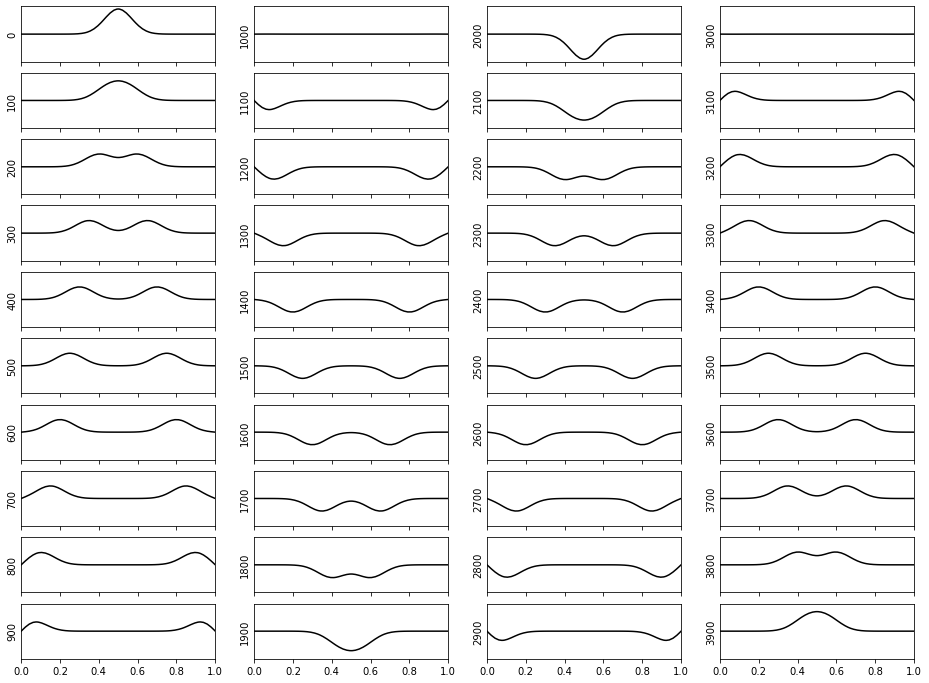

In [8]:
# Initialise the disp, vel, acc: 
disp = np.zeros(nglob)
vel  = np.zeros(nglob)
acc  = np.zeros(nglob)

# Apply initial condition: 
disp = np.exp(- 100*((xcoord-0.5)**2)) 


# Plot the initial condition
fig, ax = plt.subplots(10,4, figsize=(16,12), sharex=True, sharey=True)
ax[0,0].plot(xcoord, disp, 'k')
ax[0,0].set_ylabel(0)


# Loop in time 
iax  = 1
icol = 0
for istep in range(1,nsteps): 

    # Predictor: 
    newdisp = disp + dt*vel + 0.5*dt*dt*acc 

    # (1) Force boundary condition on displacement
    newdisp[0]  = 0
    newdisp[-1] = 0
    
    # (2) finish predictor stage
    newvel  = vel+ 0.5*dt*acc 
    newacc  = acc*0 

    # Solver: 
    Da = -np.matmul(K, newdisp) 

    # Add boundary terms for first/ last gll points 
    bNsum = 0
    for bb in range(ngll): 
        bNsum += disp[ibool[bb,-1]] * dlag1[bb,-1] / jac[-1, -1]

    Da[-1] += wgll[-1]*mu*bNsum

    b0sum = 0
    for bb in range(ngll): 
        b0sum += disp[ibool[bb,0]] * dlag1[bb,0] / jac[0, 0]
    Da[0] += wgll[0]*mu*b0sum

    # Divide by mass matrix
    DaM = Da/M

    # Corrector:
    newacc  += DaM
    newvel  += 0.5*dt*newacc


    # Now need to copy to old arrays: 
    disp[:] = copy(newdisp[:])
    vel[:]  = copy(newvel[:])    
    acc[:]  = copy(newacc[:])    

    # Once again force boundary conidition just in case
    disp[0] = 0
    disp[-1] = 0


    if istep%plotevery == 0:
        ax[iax, icol].plot(xcoord, disp, 'k')
        ax[iax, icol].set_ylabel(istep)
        ax[iax, icol].set_yticks([])

        iax += 1
        if iax==10:
            icol +=1 
            iax  = 0 
        
ax[0,0].set_xlim([0,1]);

Due to the fixed boundaries, we see a reflection of the wave where the polarity is flipped.